In [1]:
import pandas as pd
import numpy as np
import logging
import time 
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.spatial import distance
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm import tqdm
import pickle

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.default_rng(seed=42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
train_ma = pd.read_pickle("/mnt/workspace/data/pickle/paired_embedded_train_data_SC_mesa_aric.pkl")
train_af = pd.read_pickle("/mnt/workspace/data/pickle/paired_embedded_train_data_SC_aric_framingham.pkl")
train_fm = pd.read_pickle("/mnt/workspace/data/pickle/paired_embedded_train_data_SC_framingham_mesa.pkl")
test = pd.read_pickle("/mnt/workspace/data/pickle/paired_embedded_test_data.pkl")

In [4]:
print(train_ma.shape, train_af.shape, train_fm.shape, test.shape)

(17712, 10) (34378, 10) (16810, 10) (11890, 10)


### Dataset Creation

In [5]:
tr_ma_input1 = torch.tensor([x[0].numpy() for x in train_ma[['biobert_embedding_1']].to_numpy()])
tr_af_input1 = torch.tensor([x[0].numpy() for x in train_af[['biobert_embedding_1']].to_numpy()])
tr_fm_input1 = torch.tensor([x[0].numpy() for x in train_fm[['biobert_embedding_1']].to_numpy()])

tr_ma_input2 = torch.tensor([x[0].numpy() for x in train_ma[['biobert_embedding_2']].to_numpy()])
tr_af_input2 = torch.tensor([x[0].numpy() for x in train_af[['biobert_embedding_2']].to_numpy()])
tr_fm_input2 = torch.tensor([x[0].numpy() for x in train_fm[['biobert_embedding_2']].to_numpy()])

tr_ma_targets = torch.tensor([x for x in train_ma[['match']].to_numpy()]).to(torch.float32)
tr_af_targets = torch.tensor([x for x in train_af[['match']].to_numpy()]).to(torch.float32)
tr_fm_targets = torch.tensor([x for x in train_fm[['match']].to_numpy()]).to(torch.float32)

tr_ma_idx = torch.tensor([x for x in train_ma[['idx']].to_numpy()])
tr_af_idx = torch.tensor([x for x in train_af[['idx']].to_numpy()])
tr_fm_idx = torch.tensor([x for x in train_fm[['idx']].to_numpy()])

batch_size = 5000

te_input1 = torch.tensor([x[0].numpy() for x in test[['biobert_embedding_1']].to_numpy()])
te_input2 = torch.tensor([x[0].numpy() for x in test[['biobert_embedding_2']].to_numpy()])
te_targets = torch.tensor([x for x in test[['match']].to_numpy()]).to(torch.float32)
te_idx = torch.tensor([x for x in test[['idx']].to_numpy()])

tr_ma_dataset = TensorDataset(tr_ma_idx, tr_ma_input1, tr_ma_input2, tr_ma_targets)
tr_af_dataset = TensorDataset(tr_af_idx, tr_af_input1, tr_af_input2, tr_af_targets)
tr_fm_dataset = TensorDataset(tr_fm_idx, tr_fm_input1, tr_fm_input2, tr_fm_targets)

te_dataset = TensorDataset(te_idx, te_input1, te_input2, te_targets)

train_ma_data, val_ma_data = random_split(tr_ma_dataset, [14170, 3542])
train_af_data, val_af_data = random_split(tr_af_dataset, [27502, 6876])
train_fm_data, val_fm_data = random_split(tr_fm_dataset, [13448, 3362])

test_data, _ = random_split(te_dataset, [11880, 10])

train_ma_loader = DataLoader(train_ma_data, batch_size)
train_af_loader = DataLoader(train_af_data, batch_size)
train_fm_loader = DataLoader(train_fm_data, batch_size)

val_ma_loader = DataLoader(val_ma_data, batch_size)
val_af_loader = DataLoader(val_af_data, batch_size)
val_fm_loader = DataLoader(val_fm_data, batch_size)

test_loader = DataLoader(test_data, batch_size)

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  """Entry point for launching an IPython kernel.


### Model Creation

In [6]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.first_layer = nn.Linear(768, 256) 
        # also add a dropout layer (10%) after initial tests without
        self.relu = nn.ReLU()
        self.second_layer = nn.Linear(256, 128)
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.sigmoid = nn.Sigmoid()
        self.bias = nn.Parameter(torch.rand(1, 1))
        self.w = nn.Parameter(torch.rand(1, 1))

    def forward(self, inp1, inp2):
        hidden_first_1 = self.first_layer(inp1)
        hidden_first_2 = self.first_layer(inp2)
        hidden_second_1 = self.second_layer(self.relu(hidden_first_1))
        hidden_second_2 = self.second_layer(self.relu(hidden_first_2))
        similarity = self.w * self.cosine(hidden_second_1, hidden_second_2) + self.bias
        output = self.sigmoid(similarity)
        return output.T

In [7]:
model_ma = FCN()
model_af = FCN()
model_fm = FCN()

### Training

In [8]:
# init loss lists
train_loss_history = []
val_loss_history = []

In [9]:
# init index trackers
train_idx_tracker = []
val_idx_tracker = []

In [10]:
# set training hyperparameters
num_epochs = 1000
patience = 5
min_val_delta = 0

In [11]:
if torch.cuda.is_available():
    model_ma = model_ma.to('cuda')

model_ma.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_ma.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_ma_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_ma(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_ma_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_ma(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 2.306429 	 Val Loss 0.679889
Epoch 5 	 Train Loss 1.924029 	 Val Loss 0.646201
Epoch 10 	 Train Loss 1.873463 	 Val Loss 0.630841
Epoch 15 	 Train Loss 1.844431 	 Val Loss 0.622598
Epoch 20 	 Train Loss 1.819689 	 Val Loss 0.616141
Epoch 40 	 Train Loss 1.735236 	 Val Loss 0.591718
Epoch 60 	 Train Loss 1.663853 	 Val Loss 0.570990
Epoch 80 	 Train Loss 1.600030 	 Val Loss 0.552193
Epoch 100 	 Train Loss 1.540900 	 Val Loss 0.534199
Epoch 120 	 Train Loss 1.486123 	 Val Loss 0.516796
Epoch 140 	 Train Loss 1.434199 	 Val Loss 0.501114
Epoch 160 	 Train Loss 1.386253 	 Val Loss 0.485510
Epoch 180 	 Train Loss 1.340943 	 Val Loss 0.471651
Epoch 200 	 Train Loss 1.297953 	 Val Loss 0.457779
Epoch 220 	 Train Loss 1.256866 	 Val Loss 0.444987
Epoch 240 	 Train Loss 1.218118 	 Val Loss 0.432932
Epoch 260 	 Train Loss 1.181183 	 Val Loss 0.420613
Epoch 280 	 Train Loss 1.146568 	 Val Loss 0.409583
Epoch 300 	 Train Loss 1.113790 	 Val Loss 0.398623
Epoch 320 	 Train Loss

<AxesSubplot:>

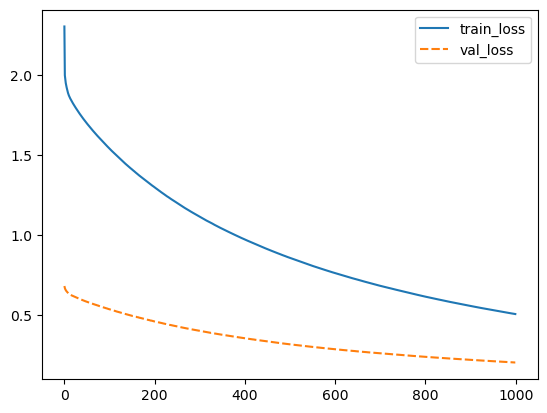

In [12]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [13]:
# save model state_dict
torch.save(model_ma.state_dict(), '/mnt/workspace/models/saved/model1_cohort_sep_ma.pth')

In [15]:
# init loss lists
train_loss_history = []
val_loss_history = []

# init index trackers
train_idx_tracker = []
val_idx_tracker = []

# set training hyperparameters
num_epochs = 1000
patience = 5
min_val_delta = 0

In [16]:
if torch.cuda.is_available():
    model_af = model_af.to('cuda')

model_af.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_af.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_af_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_af(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_af_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_af(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 5.956901 	 Val Loss 1.890697
Epoch 5 	 Train Loss 5.467183 	 Val Loss 1.819874
Epoch 10 	 Train Loss 5.350837 	 Val Loss 1.782568
Epoch 15 	 Train Loss 5.248795 	 Val Loss 1.749944
Epoch 20 	 Train Loss 5.151044 	 Val Loss 1.718918
Epoch 40 	 Train Loss 4.766716 	 Val Loss 1.601768
Epoch 60 	 Train Loss 4.428211 	 Val Loss 1.501510
Epoch 80 	 Train Loss 4.123097 	 Val Loss 1.406747
Epoch 100 	 Train Loss 3.844091 	 Val Loss 1.322437
Epoch 120 	 Train Loss 3.587483 	 Val Loss 1.244443
Epoch 140 	 Train Loss 3.354445 	 Val Loss 1.174141
Epoch 160 	 Train Loss 3.135262 	 Val Loss 1.105167
Epoch 180 	 Train Loss 2.939539 	 Val Loss 1.047427
Epoch 200 	 Train Loss 2.764710 	 Val Loss 0.989333
Epoch 220 	 Train Loss 2.598063 	 Val Loss 0.936292
Epoch 240 	 Train Loss 2.445770 	 Val Loss 0.888476
Epoch 260 	 Train Loss 2.309351 	 Val Loss 0.845247
Epoch 280 	 Train Loss 2.188953 	 Val Loss 0.804673
Epoch 300 	 Train Loss 2.072146 	 Val Loss 0.767916
Epoch 320 	 Train Loss

<AxesSubplot:>

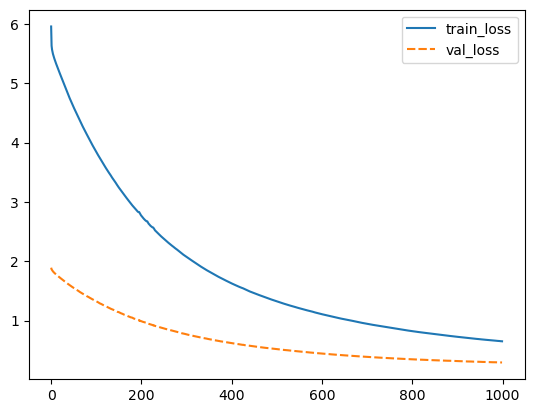

In [17]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [18]:
# save model state_dict
torch.save(model_af.state_dict(), '/mnt/workspace/models/saved/model1_cohort_sep_af.pth')

In [19]:
# init loss lists
train_loss_history = []
val_loss_history = []

# init index trackers
train_idx_tracker = []
val_idx_tracker = []

# set training hyperparameters
num_epochs = 1000
patience = 5
min_val_delta = 0

In [20]:
if torch.cuda.is_available():
    model_fm = model_fm.to('cuda')

model_fm.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_fm.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_fm_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_fm(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_fm_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_fm(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 3.459031 	 Val Loss 0.983174
Epoch 5 	 Train Loss 2.746768 	 Val Loss 0.915023
Epoch 10 	 Train Loss 2.676919 	 Val Loss 0.896153
Epoch 15 	 Train Loss 2.632404 	 Val Loss 0.885676
Epoch 20 	 Train Loss 2.596658 	 Val Loss 0.877616
Epoch 40 	 Train Loss 2.474873 	 Val Loss 0.849458
Epoch 60 	 Train Loss 2.368207 	 Val Loss 0.827632
Epoch 80 	 Train Loss 2.271879 	 Val Loss 0.806495
Epoch 100 	 Train Loss 2.185072 	 Val Loss 0.783196
Epoch 120 	 Train Loss 2.102929 	 Val Loss 0.761137
Epoch 140 	 Train Loss 2.024117 	 Val Loss 0.740613
Epoch 160 	 Train Loss 1.951701 	 Val Loss 0.718246
Epoch 180 	 Train Loss 1.885235 	 Val Loss 0.701217
Epoch 200 	 Train Loss 1.815717 	 Val Loss 0.680964
Epoch 220 	 Train Loss 1.753392 	 Val Loss 0.662300
Epoch 240 	 Train Loss 1.692868 	 Val Loss 0.642992
Epoch 260 	 Train Loss 1.633447 	 Val Loss 0.625503
Epoch 280 	 Train Loss 1.580766 	 Val Loss 0.608767
Epoch 300 	 Train Loss 1.526875 	 Val Loss 0.591501
Epoch 320 	 Train Loss

<AxesSubplot:>

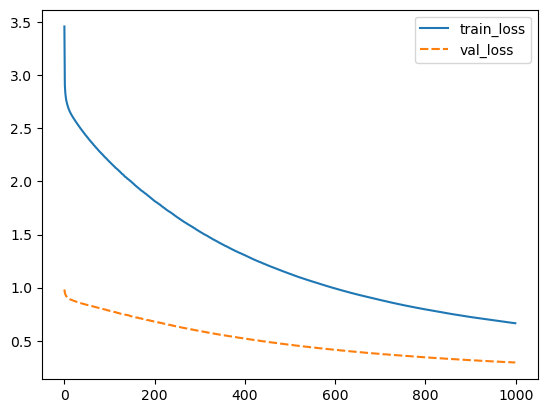

In [21]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [22]:
# save model state_dict
torch.save(model_fm.state_dict(), '/mnt/workspace/models/saved/model1_cohort_sep_fm.pth')

### Inference

In [10]:
inf_ma_model = FCN()
inf_af_model = FCN()
inf_fm_model = FCN()

inf_ma_model.load_state_dict(torch.load('/mnt/workspace/models/saved/model1_cohort_sep_ma.pth'))
inf_af_model.load_state_dict(torch.load('/mnt/workspace/models/saved/model1_cohort_sep_af.pth'))
inf_fm_model.load_state_dict(torch.load('/mnt/workspace/models/saved/model1_cohort_sep_fm.pth'))

if torch.cuda.is_available():
    inf_ma_model = inf_ma_model.to('cuda')
    inf_af_model = inf_af_model.to('cuda')
    inf_fm_model = inf_fm_model.to('cuda')
    
inf_ma_model.eval()
inf_af_model.eval()
inf_fm_model.eval()

FCN(
  (first_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (second_layer): Linear(in_features=256, out_features=128, bias=True)
  (cosine): CosineSimilarity()
  (sigmoid): Sigmoid()
)

In [11]:
outputs_ma = []
labels_ma = []
idxs_ma = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_ma.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_ma_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_ma.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_ma.append(label)

idxs_ma = np.concatenate(idxs_ma).ravel()
outputs_ma = np.concatenate(outputs_ma).ravel()
labels_ma = np.concatenate(labels_ma).ravel()

In [12]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = outputs_ma
y_test = labels_ma
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.92452135, 0.93496124])

In [13]:
outputs_af = []
labels_af = []
idxs_af = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_af.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_af_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_af.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_af.append(label)

idxs_af = np.concatenate(idxs_af).ravel()
outputs_af = np.concatenate(outputs_af).ravel()
labels_af = np.concatenate(labels_af).ravel()

In [14]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = outputs_af
y_test = labels_af
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.9726338 , 0.97747442])

In [15]:
outputs_fm = []
labels_fm = []
idxs_fm = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_fm.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_fm_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_fm.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_fm.append(label)

idxs_fm = np.concatenate(idxs_fm).ravel()
outputs_fm = np.concatenate(outputs_fm).ravel()
labels_fm = np.concatenate(labels_fm).ravel()

In [16]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = outputs_fm
y_test = labels_fm
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.85294869, 0.86963173])

In [17]:
idxs_fm

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [18]:
idxs_ma

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [19]:
idxs_af

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [20]:
outputs_ma

array([0.06243997, 0.12693729, 0.04425233, ..., 0.36957744, 0.827567  ,
       0.14013109], dtype=float32)

In [21]:
outputs_af

array([0.03365048, 0.04300292, 0.0851778 , ..., 0.04752684, 0.9321163 ,
       0.04937855], dtype=float32)

In [22]:
outputs_fm

array([0.3656394 , 0.05604987, 0.1593904 , ..., 0.35692006, 0.6662433 ,
       0.06320378], dtype=float32)

In [23]:
labels_ma

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [24]:
labels_af

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [25]:
labels_fm

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [26]:
print(sum(idxs_fm == idxs_ma), len(idxs_fm))

11880 11880


In [27]:
with open('./visualization/fcn_preds_cohort_spec_ma.pkl', 'wb') as wfile:
    pickle.dump(outputs_ma, wfile)
with open('./visualization/fcn_preds_cohort_spec_af.pkl', 'wb') as wfile:
    pickle.dump(outputs_af, wfile)
with open('./visualization/fcn_preds_cohort_spec_fm.pkl', 'wb') as wfile:
    pickle.dump(outputs_fm, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(labels_af, wfile)

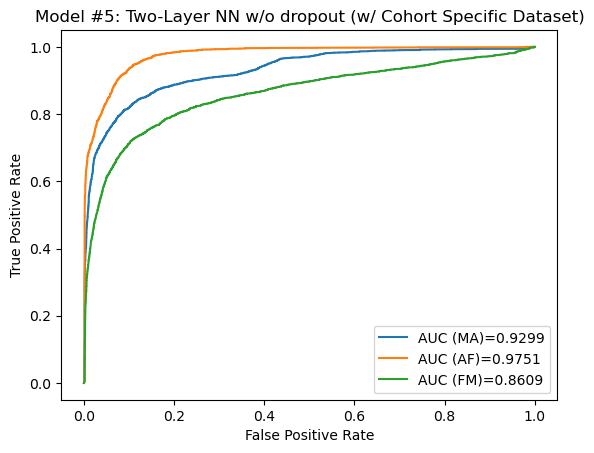

In [28]:
from sklearn import metrics

fpr_ma, tpr_ma, _ = metrics.roc_curve(labels_ma, outputs_ma)
fpr_af, tpr_af, _ = metrics.roc_curve(labels_af, outputs_af)
fpr_fm, tpr_fm, _ = metrics.roc_curve(labels_fm, outputs_fm)

auc_ma = metrics.roc_auc_score(labels_ma, outputs_ma)
auc_af = metrics.roc_auc_score(labels_af, outputs_af)
auc_fm = metrics.roc_auc_score(labels_fm, outputs_fm)

plt.plot(fpr_ma, tpr_ma, label="AUC (MA)="+str(np.round(auc_ma, 4)))
plt.plot(fpr_af, tpr_af, label="AUC (AF)="+str(np.round(auc_af, 4)))
plt.plot(fpr_fm, tpr_fm, label="AUC (FM)="+str(np.round(auc_fm, 4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #5: Two-Layer NN w/o dropout (w/ Cohort Specific Dataset)')
plt.legend(loc=4)
plt.show()

In [29]:
inf_df = test[test['idx'].isin(idxs_ma)]
inf_preds = pd.DataFrame({
    "idx": idxs_ma,
    "match": labels_ma,
    "predict_proba_ma": outputs_ma,
    "predict_proba_af": outputs_af,
    "predict_proba_fm": outputs_fm
})
inf_df = inf_df.merge(inf_preds, on=['idx', 'match'], how='inner')
inf_df.shape

(11880, 13)

In [30]:
inf_df_m = inf_df[(inf_df['study_1'] == 'MESA') & (inf_df['study_2'] == 'MESA')]
inf_df_a = inf_df[(inf_df['study_1'] == 'ARIC') & (inf_df['study_2'] == 'ARIC')]
inf_df_f = inf_df[(inf_df['study_1'] == 'Framingham') & (inf_df['study_2'] == 'Framingham')]
print(inf_df_m.shape, inf_df_a.shape, inf_df_f.shape)

(331, 13) (2244, 13) (2029, 13)


In [31]:
outputs_ma_excl = inf_df_f['predict_proba_ma'].to_list()
labels_ma_excl = inf_df_f['match'].to_list()
outputs_af_excl = inf_df_m['predict_proba_af'].to_list()
labels_af_excl = inf_df_m['match'].to_list()
outputs_fm_excl = inf_df_a['predict_proba_fm'].to_list()
labels_fm_excl = inf_df_a['match'].to_list()

In [32]:
with open('./visualization/fcn_preds_cohort_spec_ma_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_ma_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_ma_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_ma_excl, wfile)
with open('./visualization/fcn_preds_cohort_spec_af_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_af_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_af_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_af_excl, wfile)
with open('./visualization/fcn_preds_cohort_spec_fm_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_fm_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_fm_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_fm_excl, wfile)

In [33]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = np.array(outputs_af_excl)
y_test = np.array(labels_af_excl)
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.73843191, 0.83540153])

In [34]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = np.array(outputs_fm_excl)
y_test = np.array(labels_fm_excl)
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.8169812 , 0.85130112])

In [35]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = np.array(outputs_ma_excl)
y_test = np.array(labels_ma_excl)
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.8380501 , 0.87515128])

In [36]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = np.mean([outputs_af, outputs_fm, outputs_ma], axis=0)
y_test = np.mean([labels_af, labels_fm, labels_ma], axis=0)
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.97791045, 0.98214109])

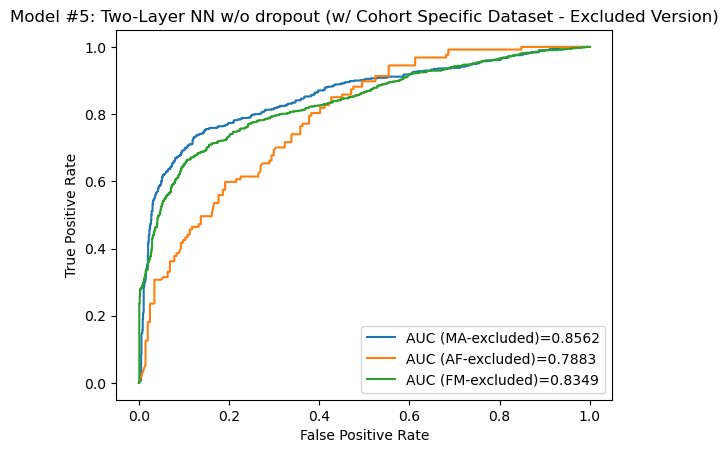

In [37]:
fpr_ma_excl, tpr_ma_excl, _ = metrics.roc_curve(labels_ma_excl, outputs_ma_excl)
fpr_af_excl, tpr_af_excl, _ = metrics.roc_curve(labels_af_excl, outputs_af_excl)
fpr_fm_excl, tpr_fm_excl, _ = metrics.roc_curve(labels_fm_excl, outputs_fm_excl)

auc_ma_excl = metrics.roc_auc_score(labels_ma_excl, outputs_ma_excl)
auc_af_excl = metrics.roc_auc_score(labels_af_excl, outputs_af_excl)
auc_fm_excl = metrics.roc_auc_score(labels_fm_excl, outputs_fm_excl)

plt.plot(fpr_ma_excl, tpr_ma_excl, label="AUC (MA-excluded)="+str(np.round(auc_ma_excl, 4)))
plt.plot(fpr_af_excl, tpr_af_excl, label="AUC (AF-excluded)="+str(np.round(auc_af_excl, 4)))
plt.plot(fpr_fm_excl, tpr_fm_excl, label="AUC (FM-excluded)="+str(np.round(auc_fm_excl, 4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #5: Two-Layer NN w/o dropout (w/ Cohort Specific Dataset - Excluded Version)')
plt.legend(loc=4)
plt.show()

In [38]:
# per-concept AUC
concepts = inf_df.concept_name_1.unique()
mauc_ovr = {}
pc_aucs = []
pc_aucs_af = []
pc_aucs_fm = []
pc_aucs_ma = []
for concept in concepts:
    print("------------------------")
    
    inf_df_concept = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)]
    print(concept, ": ", inf_df_concept.shape[0])
    
    preds = inf_df_concept[['predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']].mean(axis=1).to_list()
    preds_af = inf_df_concept.predict_proba_af.to_list()
    preds_fm = inf_df_concept.predict_proba_fm.to_list()
    preds_ma = inf_df_concept.predict_proba_ma.to_list()

    gt_labels = inf_df_concept.match.to_list()
    
    if len(inf_df_concept.match.unique()) == 1:
        print("Only single class present")
        continue
    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
    pc_aucs.append(metrics.roc_auc_score(gt_labels, preds))
    
    pc_aucs_af.append(metrics.roc_auc_score(gt_labels, preds_af))
    pc_aucs_fm.append(metrics.roc_auc_score(gt_labels, preds_fm))
    pc_aucs_ma.append(metrics.roc_auc_score(gt_labels, preds_ma))
    
    print("AUC for", concept, " : ", mauc_ovr[concept])

------------------------
AFIB :  318
AUC for AFIB  :  0.9664457332228666
------------------------
AGE :  321
AUC for AGE  :  1.0
------------------------
ALCOHOL :  249
AUC for ALCOHOL  :  1.0
------------------------
ANYCHOLMED :  1181
AUC for ANYCHOLMED  :  0.9590534896186248
------------------------
ASPIRIN :  439
AUC for ASPIRIN  :  0.8927868571917514
------------------------
BASE_CVD :  92
AUC for BASE_CVD  :  0.9888888888888889
------------------------
BASE_STROKE :  84
AUC for BASE_STROKE  :  0.99375
------------------------
BG :  136
AUC for BG  :  1.0
------------------------
BMI :  237
AUC for BMI  :  0.9996684350132626
------------------------
CARSTEN :  115
AUC for CARSTEN  :  0.9933862433862435
------------------------
CENSDAY :  51
AUC for CENSDAY  :  0.9791666666666667
------------------------
CREAT :  183
AUC for CREAT  :  1.0
------------------------
CURRSMK :  341
AUC for CURRSMK  :  1.0
------------------------
DEATH_IND :  50
AUC for DEATH_IND  :  0.7551020408163265

In [39]:
pd.DataFrame(pc_aucs).describe()

,0
count,56.000000
mean,0.960610
std,0.121605
min,0.148148
25%,0.973301
50%,0.995203
75%,1.000000
max,1.000000


In [40]:
pd.DataFrame(pc_aucs_af).describe()

,0
count,56.000000
mean,0.944605
std,0.106899
min,0.378378
25%,0.929445
50%,0.990347
75%,0.999822
max,1.000000


In [41]:
pd.DataFrame(pc_aucs_fm).describe()

,0
count,56.000000
mean,0.867304
std,0.187106
min,0.102041
25%,0.845739
50%,0.911639
75%,0.991347
max,1.000000


In [42]:
pd.DataFrame(pc_aucs_ma).describe()

,0
count,56.000000
mean,0.934189
std,0.097261
min,0.518519
25%,0.911870
50%,0.974211
75%,0.997833
max,1.000000


In [43]:
with open('./visualization/fcn_mauc_ovr_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(mauc_ovr, wfile)

In [44]:
concept = 'AFIB'
conc_inf_df = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['variable_description_1', 'concept_name_1', 'variable_description_2', 'concept_name_2', 'match', 'predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']]
conc_inf_df

,variable_description_1,concept_name_1,variable_description_2,concept_name_2,match,predict_proba_ma,predict_proba_af,predict_proba_fm
0,Atrial fibrillation,AFIB,time to incident af,AFIB,1,0.793215,0.893683,0.546107
1,Atrial fibrillation,AFIB,ATRIAL FIBRILLATION,AFIB,1,0.828124,0.934157,0.891936
2,Atrial fibrillation,AFIB,ECG-ATRIAL FIBRILLATION,AFIB,1,0.770019,0.909504,0.819112
3,Atrial fibrillation,AFIB,Atrial Fibrillation (via ICD10 Code): Time fro...,AFIB,1,0.740917,0.705538,0.833914
4,Atrial fibrillation,AFIB,"TIME BETWEEN FIRST AND FIFTH VISITS, IN DAYS",AFIB,1,0.649747,0.436323,0.390703
...,...,...,...,...,...,...,...,...
11681,YAMS/SWEET POTATOES:(servings/week),VEGETABLES,"Time between first and third visits, in days",AFIB,0,0.113858,0.051002,0.112556
11693,GREEN STRING BEANS OR ASPARAGUS,VEGETABLES,Atrial fibrillation,AFIB,0,0.209988,0.049890,0.078867
11737,WINTER SQUASH:(servings/week),VEGETABLES,Atrial fibrillation,AFIB,0,0.237220,0.041967,0.127642
11849,"Weight (pounds), Exam 1",WGT,ATRIAL FIBRILLATION,AFIB,0,0.142214,0.302643,0.280906


In [45]:
inf_df['predict_proba'] = inf_df[['predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']].mean(axis=1)
proba_1 = inf_df.loc[inf_df['match'] == 1, 'predict_proba'].to_numpy()
proba_1.sort()
proba_0 = inf_df.loc[inf_df['match'] == 0, 'predict_proba'].to_numpy()
proba_0.sort()

In [46]:
with open('./visualization/fcn_prob_match_0_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(proba_0, wfile)
with open('./visualization/fcn_prob_match_1_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(proba_1, wfile)

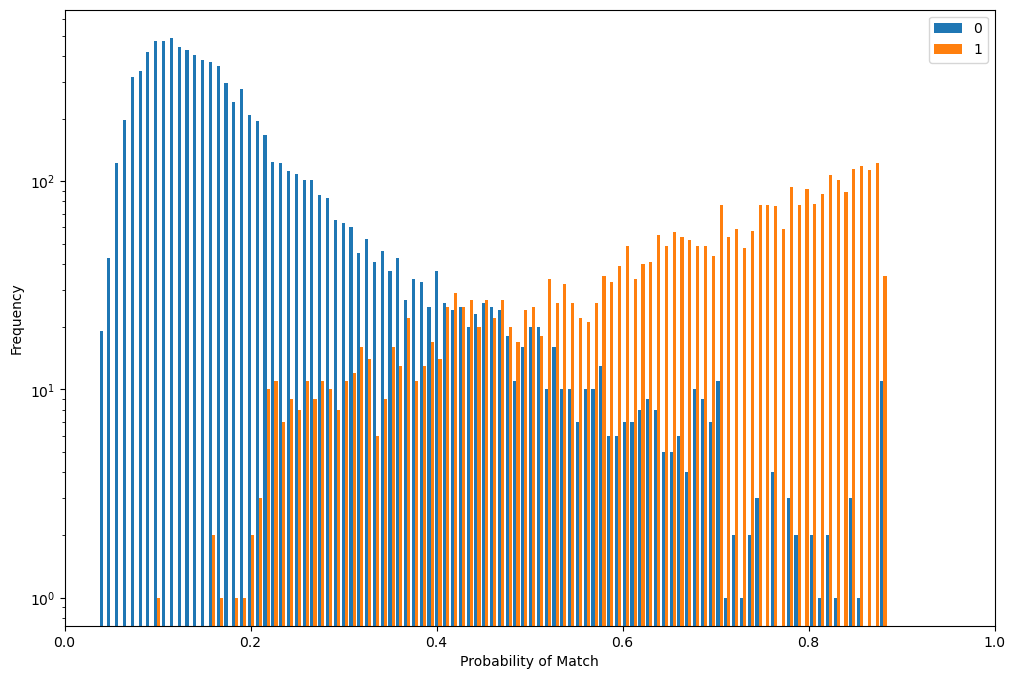

In [47]:
# plot prediction probabilities
plt.figure(figsize=(12,8))
plt.hist([proba_0, proba_1], bins=101, label=['0', '1'])
plt.legend(loc="upper right")
plt.xlabel("Probability of Match")
plt.ylabel("Frequency")
plt.xlim(0.0, 1.0)
plt.yscale('log')
plt.show()

In [48]:
violin_concepts = []
violin_match = []
violin_pred = []

In [49]:
for concept in concepts:
    match_inf_conc = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['concept_name_1','concept_name_2', 'match', 'predict_proba']]
    match_inf_conc['concept_name'] = match_inf_conc['concept_name_1'] + "," + match_inf_conc['concept_name_2']
    match_inf_conc['concept_name'] = match_inf_conc['concept_name'].str.split(",")
    match_inf_conc = match_inf_conc.explode('concept_name')
    match_inf_conc = match_inf_conc.drop(columns=['concept_name_1', 'concept_name_2'])
    match_inf_conc = match_inf_conc.drop_duplicates().reset_index(drop=True)
    violin_concepts.append(match_inf_conc['concept_name'].values)
    violin_match.append(match_inf_conc['match'].values)
    violin_pred.append(match_inf_conc['predict_proba'].values)

In [50]:
violin_df = pd.DataFrame({
    "concept": np.concatenate(violin_concepts).tolist(),
    "match": np.concatenate(violin_match).tolist(),
    "predict_proba": np.concatenate(violin_pred).tolist()
})
print(violin_df.shape)
violin_df = violin_df.sort_values("concept")

(37242, 3)


In [51]:
violin_df.to_pickle('./visualization/fcn_violin_df_cohort_spec.pkl')

<AxesSubplot:xlabel='predict_proba', ylabel='concept'>

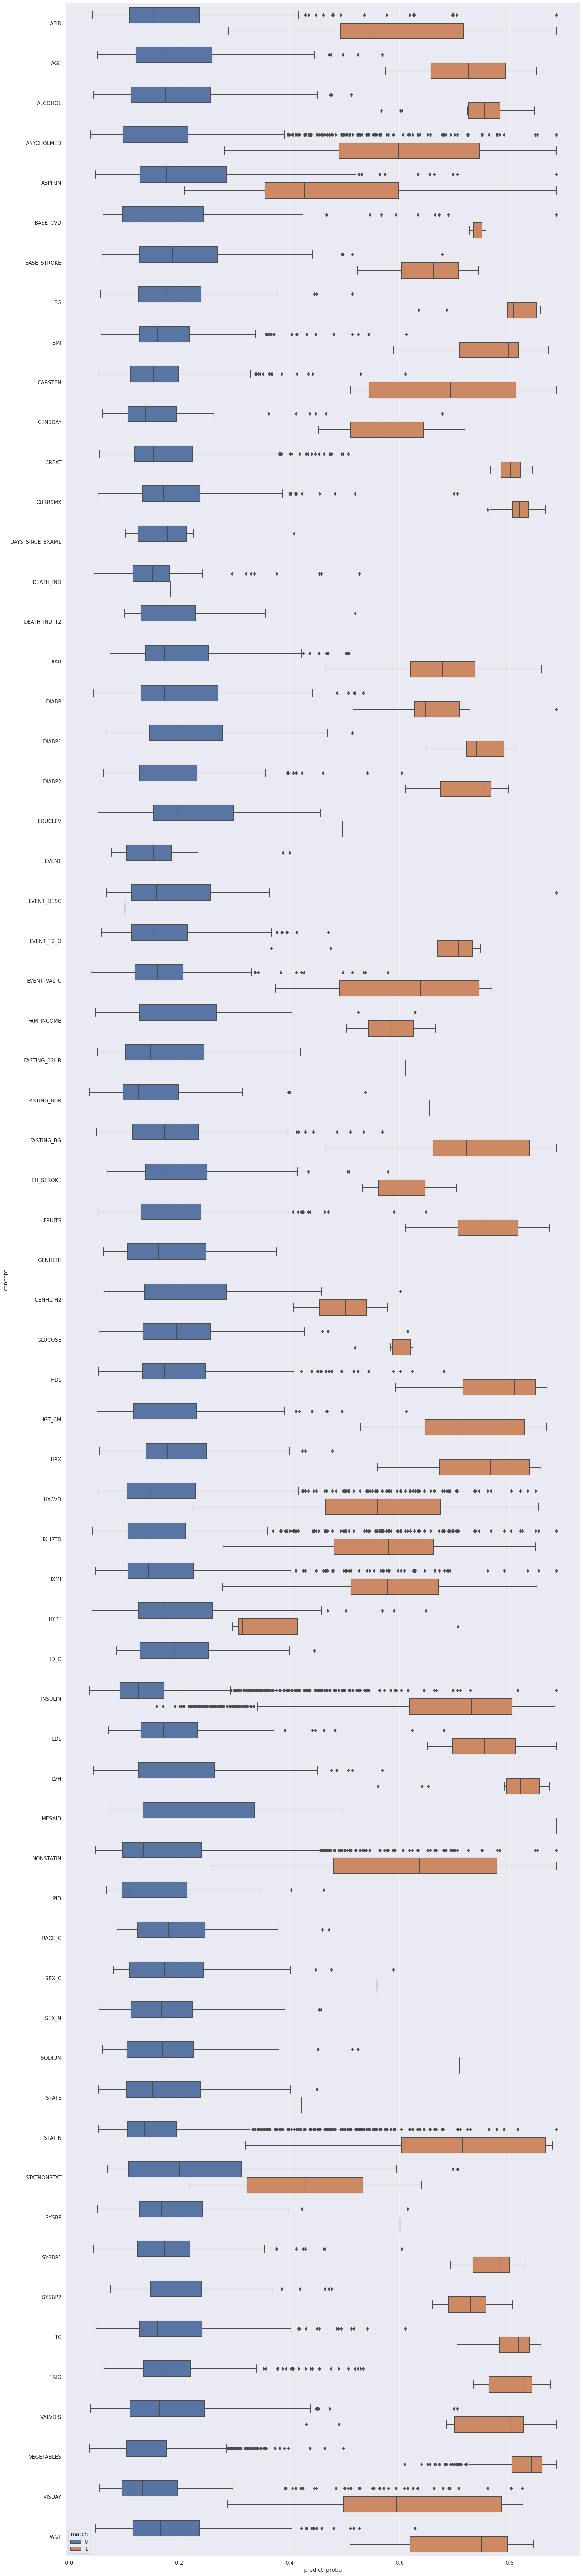

In [52]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 100)})
sns.boxplot(data=violin_df, x="predict_proba", y="concept", hue="match")

### Concept Predictor

In [53]:
df_p = pd.read_pickle("/mnt/workspace/data/pickle/predictor_data.pkl")
df_p = df_p.reset_index(drop=True)
df_p

,variable_description,concept,study,biobert_embedding
0,Atrial fibrillation,AFIB,ARIC,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
1,Incident AF,AFIB,ARIC,"[tensor(-0.0823), tensor(-0.1281), tensor(-0.3..."
2,time to incident af,AFIB,ARIC,"[tensor(0.2017), tensor(-0.1166), tensor(-0.38..."
3,DAYS SINCE EXAM 1,AFIB,ARIC,"[tensor(0.4667), tensor(-0.3528), tensor(-0.15..."
4,ATRIAL FIBRILLATION,AFIB,Framingham,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
...,...,...,...,...
944,TRIG,TRIG,None,"[tensor(0.1032), tensor(0.0132), tensor(0.0905..."
945,VALVDIS,VALVDIS,None,"[tensor(0.4729), tensor(-0.0575), tensor(-0.09..."
946,VEGETABLES,VEGETABLES,None,"[tensor(0.3033), tensor(-0.2493), tensor(-0.44..."
947,VISDAY,VISDAY,None,"[tensor(0.2013), tensor(-0.2242), tensor(-0.23..."


In [54]:
# prepare the predictor dataset
df_p_dict = {}
p_concepts = df_p[df_p['study'] == 'None']['concept'].values
p_concepts_embeds = df_p[df_p['study'] == 'None']['biobert_embedding'].values
print(len(p_concepts))

64


In [55]:
# p_var_desc = df_p.iloc[0, 0]
# p_var_concept = df_p.iloc[0, 1]
# p_var_embed = df_p.iloc[0, 3]
# p_var_input1 = torch.tensor([p_var_embed.numpy() for i in range(len(p_concepts_embeds))])
# p_var_input2 = torch.tensor([p_concept_embed.numpy() for p_concept_embed in p_concepts_embeds])
# p_var_target = torch.tensor(pd.Series(p_concepts).str.contains(p_var_concept).astype('int').to_numpy())
# df_p_dict[p_var_desc] = (p_var_input1, p_var_input2, p_var_target)

In [56]:
# p_pred_score_ma = inf_ma_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()
# p_pred_score_af = inf_af_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()
# p_pred_score_fm = inf_fm_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()

# p_pred_df = pd.DataFrame({
#     'concept_name': p_concepts,
#     'pred_score_ma': p_pred_score_ma,
#     'pred_score_af': p_pred_score_af,
#     'pred_score_fm': p_pred_score_fm
# })
# p_pred_df['pred_score'] = p_pred_df[['pred_score_ma', 'pred_score_af', 'pred_score_fm']].mean(axis=1)
# p_pred_df = p_pred_df.sort_values(by=['pred_score'], ascending=False)
# p_pred_df.head(5)

In [57]:
# df_p = df_p.drop_duplicates(subset=['variable_description'])
# df_p.shape

In [58]:
# prepare a custom function for prediction given a sentence
# ensure protobuf = 3.20.x
from biobert_embedding.embedding import BiobertEmbedding
biobert = BiobertEmbedding(model_path='/mnt/workspace/packages/biobert/')

class ConceptPredictor_Tri:
    def __init__(self, model_1, model_2, model_3, concepts, concepts_embeds):
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.concepts = concepts
        self.concepts_embeds = concepts_embeds
    
    def predict_concept(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = torch.tensor([sent_embed.numpy() for i in range(len(self.concepts_embeds))])
        input2 = torch.tensor([concept_embed.numpy() for concept_embed in self.concepts_embeds])
        pred_score_1 = self.model_1(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_score_2 = self.model_2(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_score_3 = self.model_3(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'pred_score_1': pred_score_1,
            'pred_score_2': pred_score_2,
            'pred_score_3': pred_score_3
        })
        pred_df['pred_score'] = pred_df[['pred_score_1', 'pred_score_2', 'pred_score_3']].mean(axis=1)
        pred_df = pred_df.sort_values(by=['pred_score'], ascending=False)

        return pred_df
    
    def baseline(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = [sent_embed for i in range(len(self.concepts_embeds))]
        input2 = [concept_embed for concept_embed in self.concepts_embeds]
        cos_sim = nn.CosineSimilarity(dim=0)
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'biobert_embedding_1': input1,
            'biobert_embedding_2': input2
        })
        pred_df['cosine_similarity'] = pred_df.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2).numpy(), axis=1)
        pred_df = pred_df.drop(columns=['biobert_embedding_1', 'biobert_embedding_2']).sort_values(by=['cosine_similarity'], ascending=False)
        
        return pred_df

2024-08-14 07:04:15.354783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 07:04:16.202709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-08-14 07:04:16.202830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-08-14 07:04:16.202842: W tensorflow/compiler/tf2tensorrt/utils/py_u

In [59]:
CPred = ConceptPredictor_Tri(inf_ma_model, inf_af_model, inf_fm_model, p_concepts, p_concepts_embeds)

In [60]:
tmp1 = CPred.predict_concept("ECG: RHYTHM")
tmp1

,concept_name,pred_score_1,pred_score_2,pred_score_3,pred_score
0,AFIB,0.112251,0.696984,0.654434,0.487890
12,CURRSMK,0.396547,0.535946,0.291893,0.408129
60,VALVDIS,0.110208,0.703519,0.406183,0.406637
25,FAM_INCOME,0.315120,0.664656,0.176824,0.385533
17,DIABP,0.373003,0.520222,0.228185,0.373803
...,...,...,...,...,...
57,SYSBP2,0.193814,0.042740,0.096178,0.110911
42,INSULIN,0.074268,0.016900,0.237981,0.109716
35,HGT_CM,0.049849,0.061842,0.204085,0.105259
4,ASPIRIN,0.085793,0.026945,0.188405,0.100381


In [61]:
tmp1 = CPred.baseline("ECG: RHYTHM")
tmp1

,concept_name,cosine_similarity
12,CURRSMK,0.85236317
37,HXCVD,0.85200137
28,FASTING_BG,0.8453882
19,DIABP2,0.84490925
27,FASTING_8HR,0.8438038
...,...,...
2,ALCOHOL,0.71450764
30,FRUITS,0.7136169
61,VEGETABLES,0.6829248
52,STATE,0.6652786


In [62]:
# get the top1 and top5 accuracy
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [63]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  75.764
top5 accuracy:  97.1549


In [64]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([73.1296, 78.5037])

In [65]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([95.9958, 98.2086])

In [66]:
# get the top1 and top5 accuracy (MA model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_1'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [68]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  55.4268
top5 accuracy:  76.5016


In [69]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([52.2655, 58.6934])

In [70]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([73.7619, 79.2413])

In [71]:
# get the top1 and top5 accuracy (AF model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_2'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [72]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  71.2329
top5 accuracy:  88.5142


In [73]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([68.385165, 74.080635])

In [74]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([86.6175, 90.5163])

In [75]:
# get the top1 and top5 accuracy (FM model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_3'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [76]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  52.7924
top5 accuracy:  75.5532


In [77]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([49.6312, 55.9536])

In [78]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([72.7081  , 78.084835])

In [79]:
# get the top1 and top5 accuracy (baseline)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.baseline(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [80]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  12.118
top5 accuracy:  22.2339


In [81]:
df_p_af = df_p[df_p['study'].isin(['MESA', 'None'])]
# get the top1 and top5 accuracy (AF model)
top1 = []
top5 = []
for idx, row in df_p_af.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_2'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  49.3333
top5 accuracy:  64.0


In [82]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([43.1111, 55.1111])

In [83]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([57.7778   , 69.3444125])

In [84]:
df_p_fm = df_p[df_p['study'].isin(['ARIC', 'None'])]
# get the top1 and top5 accuracy (FM model)
top1 = []
top5 = []
for idx, row in df_p_fm.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_3'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  32.9815
top5 accuracy:  48.8127


In [85]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([28.2322, 37.467 ])

In [86]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([43.7995, 53.562 ])

In [87]:
df_p_ma = df_p[df_p['study'].isin(['Framingham', 'None'])]
# get the top1 and top5 accuracy (MA model)
top1 = []
top5 = []
for idx, row in df_p_ma.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_1'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  39.3235
top5 accuracy:  59.6195


In [88]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([35.0951, 43.7632])

In [89]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([55.3911, 64.0592])